In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld, matsz, rank):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.matsz = matsz
        self.rank = rank
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)

    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        x = x.reshape(len(z), self.matsz, self.rank)
        x = torch.einsum('abc,adc->abd', x, x)
        return x

    def vectorize(self, x):
        a,b = np.triu_indices(self.matsz, 1)
        return x[:,a,b]

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(34716, 30, 264, 5)
vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6_264_rank5.torch'))
vae.eval()

print('Done')

Done


In [2]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [3]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []
wrat = []
subids = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        ra = demo['Race'][sub]
        ag = demo['age_at_cnb'][sub]
        se = demo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(remap(vec2mat(r))[a,b])
        nback.append(remap(vec2mat(n))[a,b])
        emoid.append(remap(vec2mat(e))[a,b])
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

# age = (age - np.mean(age)) / np.std(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [179]:
class VAEKL(nn.Module):
    def __init__(self, ld):
        super(VAEKL, self).__init__()
        self.ld = ld
        self.enc1 = nn.Linear(34716, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, 34716).float().cuda()

    def enc(self, x):
        z = F.relu(self.enc1(x))
        z = self.enc2(z)
        return z

    def dec(self, z):
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

    def gen(self, n):
        z = torch.randn(n, self.ld).float().cuda()
        return self.dec(z)

    def forward(self, x):
        z = self.enc(x)
        xhat = self.dec(z)
        return xhat, z

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def klloss(z):
    N = z.shape[1]
    sigma = torch.std(z, dim=0)
    mu = torch.mean(z, dim=0)
    loss = torch.sum(sigma**2)+torch.sum(mu**2)-2*torch.sum(torch.log(sigma))
    return loss

def pretty(a):
    return f'{round(float(a), 4)}'

vaekl = VAEKL(30)
optim = torch.optim.Adam(vaekl.parameters(), lr=1e-4, weight_decay=1e-4)

nepochs = 1000
pperiod = 50

x = torch.from_numpy(rest).float().cuda()

for e in range(nepochs):
    optim.zero_grad()
    xhat, z = vaekl(x)
    loss_recon = rmse(xhat, x)
    loss_kl = klloss(z)
    (loss_recon+loss_kl).backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_recon)} {pretty(loss_kl)}')

print('Done')

0 0.3867 181.7239
50 0.228 30.21
100 0.2117 30.0008
150 0.202 30.0
200 0.1951 30.0
250 0.1907 30.0
300 0.1877 30.0
350 0.1857 30.0
400 0.1843 30.0
450 0.183 30.1528
500 0.1825 30.0034
550 0.1818 30.0001
600 0.1813 30.0063
650 0.1816 30.2558
700 0.1805 30.0008
750 0.1804 30.0232
800 0.1804 30.0051
850 0.18 30.2458
900 0.1793 30.0006
950 0.1791 30.0194
999 0.1791 30.4647
Done


In [145]:
n = 1000

with torch.no_grad():
    age = torch.randn(n).float().cuda()
    sex = torch.randint(high=2, size=(n,)).float().cuda()
    race = torch.randint(high=2, size=(n,)).float().cuda()
    task = torch.randint(high=3, size=(n,)).float().cuda()
    rt = torch.ones(n).float().cuda()
    nt = torch.zeros(n).float().cuda()
    et = torch.zeros(n).float().cuda()
    # rt[task == 0] = 1
    # nt[task == 1] = 1
    # et[task == 2] = 1
    z = vae.gen(n)
    fake = vae.dec(z, age, sex, race, rt, nt, et)
    fake = fake.detach().cpu().numpy()
    a, b = np.triu_indices(264,1)
    fake = fake[:,a,b]

print(fake.shape)

(1000, 34716)


In [180]:
with torch.no_grad():
    fakebad = vaekl.gen(n).detach().cpu().numpy()

print(fakebad.shape)

(1000, 34716)


In [121]:
# GAN

import random

mygen = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/mygen2.pkl', 'rb'))

def gen(n, age, sex, race, task='rest', var=False):
    rest = int(task == 'rest')
    nback = int(task == 'nback')
    emoid = int(task == 'emoid')
    x = np.random.normal(loc=0, scale=1, size=(n, 10))
    y = np.concatenate([
        np.ones((n,1))*age,
        np.ones((n,1))*sex,
        np.ones((n,1))*(1-sex),
        np.ones((n,1))*race,
        np.ones((n,1))*(1-race),
        np.ones((n,1))*rest,
        np.ones((n,1))*nback,
        np.ones((n,1))*emoid], axis=1)
    x = np.concatenate([x, y], axis=1)
    w1 = mygen['gen_enc1_w']
    b1 = mygen['gen_enc1_bias']
    x = x @ w1 + b1
    # ReLU
    x[x < 0] = 0
    w2 = mygen['gen_enc2_w']
    b2 = mygen['gen_enc2_bias']
    x = x @ w2 + b2
    # AE Decode
    w3 = mygen['enc_dec1_w']
    b3 = mygen['enc_dec1_bias']
    x = x @ w3 + b3
    x = x.reshape((n, 264, 5))
    x = np.einsum('ijk,ilk->ijl', x, x)
    # Clamp non-real values
    for i in range(len(x)):
        mx = np.max(np.abs(x[i]))  
        if mx > 1:
            x[x > 1] = 1
            x[x < -1] = -1
    if var:
        x = np.var(x, axis=0)
    else:
        x = np.mean(x, axis=0)
    return x

gans = []

for _ in range(n):
    ag = random.randint(8,22)
    se = random.randint(0,1)
    ra = random.randint(0,1)
    gan = gen(1,ag,se,ra)
    gans.append(gan[a,b])

gans = np.stack(gans)
print(gans.shape)

(1000, 34716)


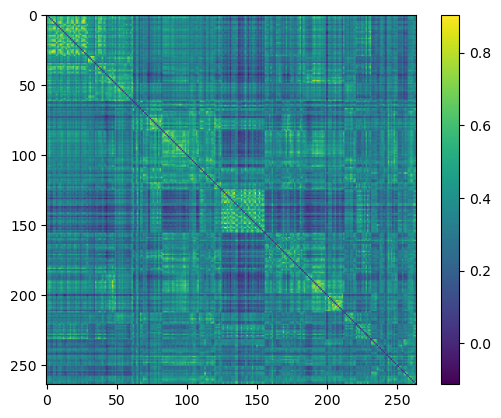

In [182]:
X = vec2mat(fakebad[1])
plt.imshow(X)
plt.colorbar()
plt.show()

In [183]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(np.concatenate([rest,fake,gans,fakebad]))
rest_tsne = tsne[:len(rest)]
fake_tsne = tsne[len(rest):len(rest)+len(fake)]
gans_tsne = tsne[len(rest)+len(fake):len(rest)+len(fake)+len(gans)]
fakebad_tsne = tsne[len(rest)+len(fake)+len(gans):]

print('Done')

Done


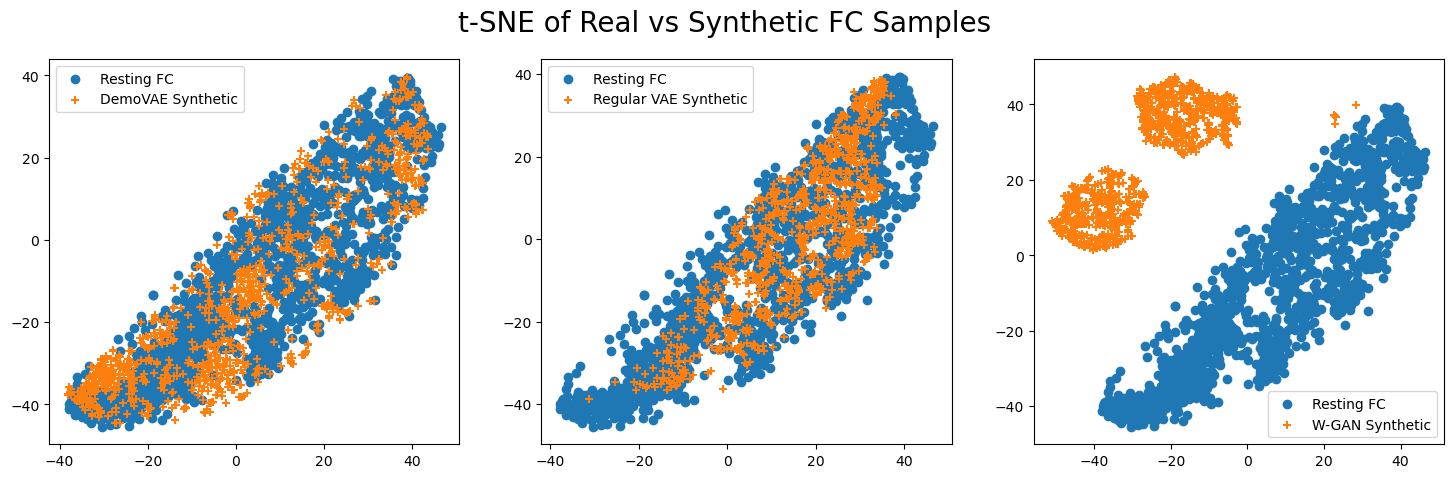

In [188]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(18,5))

ax[0].scatter(rest_tsne[:,0], rest_tsne[:,1], label='Resting FC')
ax[0].scatter(fake_tsne[:,0], fake_tsne[:,1], s=35, marker='+', label='DemoVAE Synthetic')

ax[1].scatter(rest_tsne[:,0], rest_tsne[:,1], label='Resting FC')
ax[1].scatter(fakebad_tsne[:,0], fakebad_tsne[:,1], s=35, marker='+', label='Regular VAE Synthetic')

ax[2].scatter(rest_tsne[:,0], rest_tsne[:,1], label='Resting FC')
ax[2].scatter(gans_tsne[:,0], gans_tsne[:,1], s=35, marker='+', label='W-GAN Synthetic')

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.suptitle('t-SNE of Real vs Synthetic FC Samples', fontsize=20)
fig.savefig('/home/anton/Documents/Tulane/Research/Work/CL-VAE/tsne-fc.pdf')
fig.show()

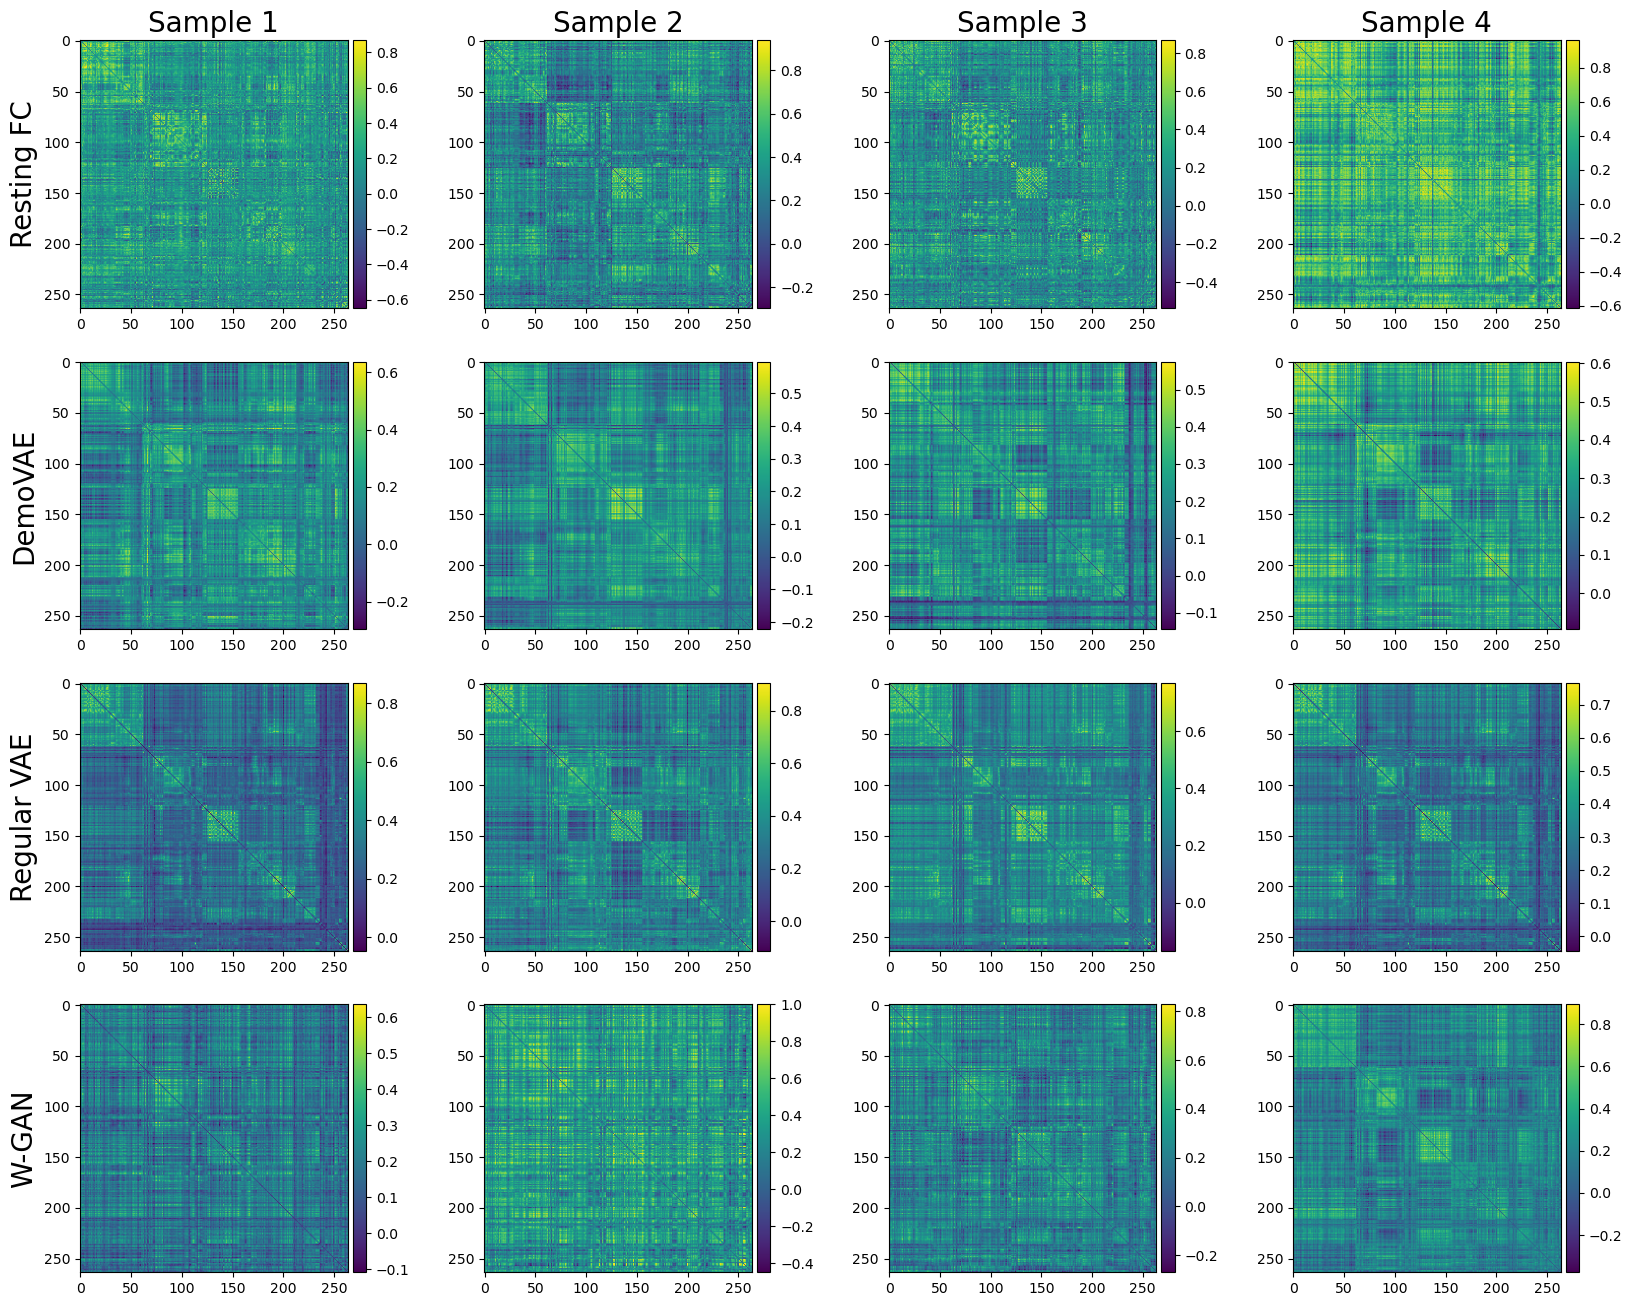

In [193]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(4,4,figsize=(20,16))

for i in range(4):
    im = ax[0,i].imshow(vec2mat(rest[i]))

    divider = make_axes_locatable(ax[0,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax[1,i].imshow(vec2mat(fake[40+i]))

    divider = make_axes_locatable(ax[1,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax[2,i].imshow(vec2mat(fakebad[i]))

    divider = make_axes_locatable(ax[2,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax[3,i].imshow(vec2mat(gans[i]))

    divider = make_axes_locatable(ax[3,i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    fig.colorbar(im, cax=cax, orientation='vertical')

ax[0,0].set_ylabel('Resting FC', fontsize=20)
ax[1,0].set_ylabel('DemoVAE', fontsize=20)
ax[2,0].set_ylabel('Regular VAE', fontsize=20)
ax[3,0].set_ylabel('W-GAN', fontsize=20)
ax[0,0].set_title('Sample 1', fontsize=20)
ax[0,1].set_title('Sample 2', fontsize=20)
ax[0,2].set_title('Sample 3', fontsize=20)
ax[0,3].set_title('Sample 4', fontsize=20)

fig.savefig('/home/anton/Documents/Tulane/Research/Work/CL-VAE/samples.pdf')
fig.show()